In [1]:
import pandas as pd
import numpy as np
import os
import json
import cv2
import lightning.pytorch as pl
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.utils as utils
import torchvision.transforms.functional as tf
import torch.nn.functional as f
import torchvision
import torchmetrics as metrics
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import LearningRateMonitor
from PIL import Image, ImageColor
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchinfo import summary
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.model_selection import train_test_split
from pathlib import Path
from unetArch import UNet, dice_loss, multiclass_dice_coef
from torchmetrics.functional.classification import multilabel_precision, multilabel_recall

In [2]:
colors = [
    (255, 255, 255), # Background (white)
    (102, 255, 51),    # Normal (blue)
    (51, 255, 153),  # Polyp (cyanic green)
    (204, 255, 51),  # Serrated adenoma (yelowish green)
    (255, 255, 0),  # Low-grade IN (yellow)
    (255, 153, 0), # High-grade IN (orange)
    (204, 51, 0), # Adenocarcinoma (red)
]

# Data preps(System)

In [4]:
trainDf = pd.read_csv('traindata.csv')
valDf = pd.read_csv('valdata.csv')
testDf = pd.read_csv('testdata.csv')

In [17]:
trainDf['Path'] = trainDf['Path'].str.strip()

In [18]:
trainDf

,Path
0,EBHI-SEG/Polyp/image/GTXC2110503-1-400-002.png
1,EBHI-SEG/Low-grade IN/image/GTDC2101366-1-400-...
2,EBHI-SEG/Adenocarcinoma/image/GTXC2012151-2-40...
3,EBHI-SEG/Polyp/image/GT2012191-1-400-002.png
4,EBHI-SEG/Adenocarcinoma/image/GTXC2015349-2-40...
...,...
1553,EBHI-SEG/Normal/image/GT2100144-1-400-004.png
1554,EBHI-SEG/Adenocarcinoma/image/GTXC2110135-2-40...
1555,EBHI-SEG/Adenocarcinoma/image/GT2001849-1-400-...
1556,EBHI-SEG/Adenocarcinoma/image/GTXC2015413-3-40...


In [27]:
dataDir = Path('EBHI-SEG')
# dataDict = {'imagePath' : [],
#             'labelPath' : [],
#             'className' : []}

classNames = [classes for classes in os.listdir(dataDir) if os.path.isdir(os.path.join(dataDir, classes))]
imageList = []
labelList = []
classList = []
splitClass = []
trainList = trainDf['Path'].tolist()
valList = valDf['Path'].tolist()
testList = testDf['Path'].tolist()

for className in classNames:
    classDir = os.path.join(dataDir, className)
    imageDir = os.path.join(classDir, 'image')
    labelDir = os.path.join(classDir, 'label')
    imagePath = [file for file in os.listdir(imageDir)]
    labelPath = [file for file in os.listdir(labelDir)]
    # for img, lbl in zip(imagePath, labelPath):
    #     if str(img).lower() == str(lbl).lower():
    #         imageList.append(os.path.join(imageDir, img))
    #         labelList.append(os.path.join(labelDir, lbl))
    #         classList.append(className)
    for img in imagePath:
        if img in labelPath:
            imageList.append(os.path.join(imageDir, img))
            labelList.append(os.path.join(labelDir, img))
            classList.append(className)
            if os.path.join(imageDir, img) in trainList:
                splitClass.append('train')
            elif os.path.join(imageDir, img) in valList:
                splitClass.append('validation')
            else:
                splitClass.append('testing')

In [28]:
df = pd.DataFrame({'image' : imageList, 'label' : labelList, 'class' : classList, 'split' : splitClass})

In [29]:
df['split'].unique()

array(['train', 'testing', 'validation'], dtype=object)

In [48]:
for folder in dataDir.iterdir():
    if folder.is_dir():
        for folder2 in folder.iterdir():
            if folder2.is_dir():
                print(folder.name)
                print(folder2.name)
                print()

Low-grade IN
label
637
Low-grade IN
image
639
Adenocarcinoma
label
795
Adenocarcinoma
image
795
High-grade IN
label
186
High-grade IN
image
186
Normal
label
76
Normal
image
76
Polyp
label
474
Polyp
image
474
Serrated adenoma
label
58
Serrated adenoma
image
58


In [30]:
df.to_csv('imageLabel.csv', index=False)

# Data preps

In [3]:
df = pd.read_csv('imageLabel.csv')
# df.drop(df.columns[0], axis=1, inplace=True)
df

,image,label,class,split
0,EBHI-SEG/Low-grade IN/image/GTXC2014165-2-400-...,EBHI-SEG/Low-grade IN/label/GTXC2014165-2-400-...,Low-grade IN,train
1,EBHI-SEG/Low-grade IN/image/GTXC2015407-1-400-...,EBHI-SEG/Low-grade IN/label/GTXC2015407-1-400-...,Low-grade IN,train
2,EBHI-SEG/Low-grade IN/image/GTxc2012481-1-400-...,EBHI-SEG/Low-grade IN/label/GTxc2012481-1-400-...,Low-grade IN,train
3,EBHI-SEG/Low-grade IN/image/GTxc2014132-1-400-...,EBHI-SEG/Low-grade IN/label/GTxc2014132-1-400-...,Low-grade IN,train
4,EBHI-SEG/Low-grade IN/image/GTxc2012967-1-400-...,EBHI-SEG/Low-grade IN/label/GTxc2012967-1-400-...,Low-grade IN,train
...,...,...,...,...
2221,EBHI-SEG/Serrated adenoma/image/GTDC2102188-2-...,EBHI-SEG/Serrated adenoma/label/GTDC2102188-2-...,Serrated adenoma,train
2222,EBHI-SEG/Serrated adenoma/image/GTXC2014129-2-...,EBHI-SEG/Serrated adenoma/label/GTXC2014129-2-...,Serrated adenoma,train
2223,EBHI-SEG/Serrated adenoma/image/GT2016855-1-40...,EBHI-SEG/Serrated adenoma/label/GT2016855-1-40...,Serrated adenoma,testing
2224,EBHI-SEG/Serrated adenoma/image/GTXC2014129-2-...,EBHI-SEG/Serrated adenoma/label/GTXC2014129-2-...,Serrated adenoma,train


In [34]:
df[df['split'] == 'train']

,image,label,class,split
0,EBHI-SEG/Low-grade IN/image/GTXC2014165-2-400-...,EBHI-SEG/Low-grade IN/label/GTXC2014165-2-400-...,Low-grade IN,train
1,EBHI-SEG/Low-grade IN/image/GTXC2015407-1-400-...,EBHI-SEG/Low-grade IN/label/GTXC2015407-1-400-...,Low-grade IN,train
2,EBHI-SEG/Low-grade IN/image/GTxc2012481-1-400-...,EBHI-SEG/Low-grade IN/label/GTxc2012481-1-400-...,Low-grade IN,train
3,EBHI-SEG/Low-grade IN/image/GTxc2014132-1-400-...,EBHI-SEG/Low-grade IN/label/GTxc2014132-1-400-...,Low-grade IN,train
4,EBHI-SEG/Low-grade IN/image/GTxc2012967-1-400-...,EBHI-SEG/Low-grade IN/label/GTxc2012967-1-400-...,Low-grade IN,train
...,...,...,...,...
2220,EBHI-SEG/Serrated adenoma/image/GTXC2014129-2-...,EBHI-SEG/Serrated adenoma/label/GTXC2014129-2-...,Serrated adenoma,train
2221,EBHI-SEG/Serrated adenoma/image/GTDC2102188-2-...,EBHI-SEG/Serrated adenoma/label/GTDC2102188-2-...,Serrated adenoma,train
2222,EBHI-SEG/Serrated adenoma/image/GTXC2014129-2-...,EBHI-SEG/Serrated adenoma/label/GTXC2014129-2-...,Serrated adenoma,train
2224,EBHI-SEG/Serrated adenoma/image/GTXC2014129-2-...,EBHI-SEG/Serrated adenoma/label/GTXC2014129-2-...,Serrated adenoma,train


In [35]:
df[df['split'] == 'validation']

,image,label,class,split
20,EBHI-SEG/Low-grade IN/image/GTXC2015417-1-400-...,EBHI-SEG/Low-grade IN/label/GTXC2015417-1-400-...,Low-grade IN,validation
23,EBHI-SEG/Low-grade IN/image/GTxc2012468-2-400-...,EBHI-SEG/Low-grade IN/label/GTxc2012468-2-400-...,Low-grade IN,validation
25,EBHI-SEG/Low-grade IN/image/GTxc2013458-2-400-...,EBHI-SEG/Low-grade IN/label/GTxc2013458-2-400-...,Low-grade IN,validation
29,EBHI-SEG/Low-grade IN/image/GTxc2013943-1-400-...,EBHI-SEG/Low-grade IN/label/GTxc2013943-1-400-...,Low-grade IN,validation
30,EBHI-SEG/Low-grade IN/image/GTXC2015407-1-400-...,EBHI-SEG/Low-grade IN/label/GTXC2015407-1-400-...,Low-grade IN,validation
...,...,...,...,...
2203,EBHI-SEG/Serrated adenoma/image/GTXC2014129-4-...,EBHI-SEG/Serrated adenoma/label/GTXC2014129-4-...,Serrated adenoma,validation
2206,EBHI-SEG/Serrated adenoma/image/GTXC2014129-4-...,EBHI-SEG/Serrated adenoma/label/GTXC2014129-4-...,Serrated adenoma,validation
2212,EBHI-SEG/Serrated adenoma/image/GTDC2102188-2-...,EBHI-SEG/Serrated adenoma/label/GTDC2102188-2-...,Serrated adenoma,validation
2216,EBHI-SEG/Serrated adenoma/image/GTDC2102188-2-...,EBHI-SEG/Serrated adenoma/label/GTDC2102188-2-...,Serrated adenoma,validation


In [37]:
df[df['split'] == 'testing']['class']

13          Low-grade IN
18          Low-grade IN
39          Low-grade IN
48          Low-grade IN
49          Low-grade IN
              ...       
2157               Polyp
2159               Polyp
2190    Serrated adenoma
2215    Serrated adenoma
2223    Serrated adenoma
Name: class, Length: 221, dtype: object

In [4]:
classes = {
    'Normal' : 1,
    'Polyp' : 2,
    'Low-grade IN' : 4,
    'High-grade IN' : 5,
    'Serrated adenoma' : 3,
    'Adenocarcinoma' : 6
}

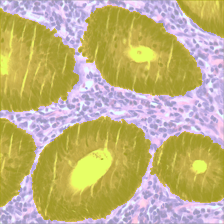

In [5]:
# img = Image.open(df.iloc[0,1]).convert('L')
# # print(img.shape)
# # print(img)
# # print(np.unique(img))
# imgArr = np.array(img)
# # print(np.unique(imgArr))
# binary = (imgArr > 0).astype(np.uint8) * 255
# print(np.unique(binary))
# # img.show()
# # print(imgArr.shape)

# img = cv2.imread(df.iloc[0,1])
# img = np.array(img)
# binary = (img > 0).astype(np.uint8) * 255
# plt.imshow(binary)

colorMap = np.array(colors, dtype=np.uint8)
img = Image.open(df.iloc[0,0])
lbl = np.array(Image.open(df.iloc[0,1]))
lblBin = (lbl > 0).astype(np.uint8) * classes[df.iloc[0,2]]
# lblBin = Image.fromarray(lblBin).convert('RGB')
coloredBin = Image.fromarray(colorMap[lblBin]).convert('RGB')
overlay = Image.blend(img, coloredBin, alpha=.6)
overlay.show()

In [6]:
df['class'].unique()

array(['Low-grade IN', 'Adenocarcinoma', 'High-grade IN', 'Normal',
       'Polyp', 'Serrated adenoma'], dtype=object)

In [5]:
class customDataset(Dataset):
    def __init__(self, imageList, labelList, classList, classDict, transforms=None):
        assert len(imageList) == len(labelList) and len(imageList) == len(classList) and len(labelList) == len(classList), '3 of the list are not the same length'
        self.imageList = imageList
        self.labelList = labelList
        self.classList = classList
        self.classDict = classDict
        self.transforms = transforms
    def __len__(self):
        return len(self.imageList)
    def __getitem__(self, index):
        image = np.array(Image.open(self.imageList[index]))
        mask = np.array(Image.open(self.labelList[index]))
        mask = (mask > 0).astype(np.uint8) * self.classDict[self.classList[index]]
        if self.transforms:
            transformed = self.transforms(image=image, mask=mask)
            imgAug = transformed['image'].contiguous()
            maskAug = transformed['mask'].contiguous()
            return imgAug, maskAug
        image = torch.as_tensor(image).float().contiguous()
        mask = torch.as_tensor(mask).long().contiguous()
        return image, mask

class dataModule(pl.LightningDataModule):
    def __init__(self, df, classDict, batchSize):
        super().__init__()
        self.df = df
        self.batchSize = batchSize
        self.classDict = classDict
    def prepare_data(self):
        #No data download, so we pass this
        pass
    def _getTransform(self,train=True):
        if train:
            return A.Compose([
                A.OneOf([
                    A.VerticalFlip(),
                    A.HorizontalFlip(),
                    A.RandomRotate90(),
                ], p=.5),
                ToTensorV2()
            ])
        return A.Compose([
            ToTensorV2()
        ])
    def setup(self, stage: str):
        trainTransform = self._getTransform()
        valTransform = self._getTransform(False)
        self.trainingSet = customDataset(df[df['split'] == 'train']['image'].tolist(), df[df['split'] == 'train']['label'].tolist(), df[df['split'] == 'train']['class'].tolist(), classDict=self.classDict, transforms=trainTransform)
        self.valSet = customDataset(df[df['split'] == 'validation']['image'].tolist(), df[df['split'] == 'validation']['label'].tolist(), df[df['split'] == 'validation']['class'].tolist(), classDict=self.classDict, transforms=valTransform)
        self.testSet = customDataset(df[df['split'] == 'testing']['image'].tolist(), df[df['split'] == 'testing']['label'].tolist(), df[df['split'] == 'testing']['class'].tolist(), classDict=self.classDict, transforms=valTransform)
    def train_dataloader(self):
        return DataLoader(self.trainingSet, batch_size=self.batchSize, num_workers=8, drop_last=True, pin_memory=True, shuffle=True)
    def val_dataloader(self):
        return DataLoader(self.valSet, batch_size=self.batchSize, num_workers=8, drop_last=True, pin_memory=True, shuffle=False)
    def predict_dataloader(self):
        return DataLoader(self.testSet, batch_size=self.batchSize, num_workers=8, drop_last=True, pin_memory=True, shuffle=False)

In [6]:
model = UNet(n_channels=3, n_classes=5)
summary(model, input_size=(1,3,224,224))

Layer (type:depth-idx)                        Output Shape              Param #
UNet                                          [1, 5, 224, 224]          --
├─DoubleConv: 1-1                             [1, 64, 224, 224]         --
│    └─Sequential: 2-1                        [1, 64, 224, 224]         --
│    │    └─Conv2d: 3-1                       [1, 64, 224, 224]         1,728
│    │    └─BatchNorm2d: 3-2                  [1, 64, 224, 224]         128
│    │    └─ReLU: 3-3                         [1, 64, 224, 224]         --
│    │    └─Conv2d: 3-4                       [1, 64, 224, 224]         36,864
│    │    └─BatchNorm2d: 3-5                  [1, 64, 224, 224]         128
│    │    └─ReLU: 3-6                         [1, 64, 224, 224]         --
├─Down: 1-2                                   [1, 128, 112, 112]        --
│    └─Sequential: 2-2                        [1, 128, 112, 112]        --
│    │    └─MaxPool2d: 3-7                    [1, 64, 112, 112]         --
│    │    └

In [9]:
class UNetModule(pl.LightningModule):
    def __init__(self, nClasses = 7, lr= 0.01, decay=0):
        super().__init__()
        self.model = UNet(n_channels=3, n_classes=nClasses)
        self.nClasses = nClasses
        self.lr = lr
        self.decay = decay
        self.save_hyperparameters()
        self.criterion = nn.CrossEntropyLoss()
    def forward(self, x):
        logits = self.model(x)
        return logits
    def training_step(self, batch, batch_idx):
        img, mask = batch
        img = img.to(device=self.device, dtype=torch.float32, memory_format=torch.channels_last)
        mask = mask.to(device=self.device, dtype=torch.long)
        predMask = self.forward(img)
        loss = self.criterion(predMask, mask)
        loss += dice_loss(f.softmax(predMask, dim=1).float(), f.one_hot(mask, self.nClasses).permute(0, 3, 1, 2).float(), multiclass=True)
        self.log('diceLoss', loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss
    def validation_step(self, batch, batch_idx):
        img, mask = batch
        totalN = self.trainer.num_val_batches[0]
        img = img.to(device=self.device, dtype=torch.float32, memory_format=torch.channels_last)
        mask = mask.to(device=self.device, dtype=torch.long)
        assert mask.min() >= 0 and mask.max() < self.nClasses, f'True mask indices should be in [0, {self.nClasses}]'
        predMask = self.forward(img)
        mask = f.one_hot(mask, self.nClasses).permute(0, 3, 1, 2).float()
        predMask = f.one_hot(predMask.argmax(dim=1), self.nClasses).permute(0, 3, 1, 2).float()
        diceScore = multiclass_dice_coef(predMask[:,1:], mask[:, 1:], reduce_batch_first=False)
        self.log('diceScore', diceScore, on_step=False, on_epoch=True, prog_bar=True, reduce_fx=torch.mean)
        return diceScore
    def predict_step(self, batch, batch_idx):
        img, mask = batch
        img = img.to(device =self.device, dtype=torch.float32)
        outputs = self.forward(img)
        predMask = outputs.argmax(dim=1)

        mask = f.one_hot(mask.long(), self.nClasses).permute(0, 3, 1, 2).float()
        predictionMask = f.one_hot(predMask.cpu(), self.nClasses).permute(0, 3, 1, 2).float()

        return img, predMask.long().squeeze().cpu().numpy(), mask, predictionMask
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.decay)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, mode='min')
        return {
            'optimizer' : optimizer,
            'lr_scheduler' : {
                'scheduler' : scheduler,
                'monitor' : 'diceLoss'
            }
        }
        # return optimizer

In [10]:
dataMod = dataModule(df=df, classDict=classes, batchSize=16)
model = UNetModule()
lrMonitor = LearningRateMonitor(logging_interval='epoch')
logger = TensorBoardLogger('tb_logs', name='UNetSegm')
trainer = pl.Trainer(accelerator='gpu', devices=[0], max_epochs=1, logger=logger, callbacks=[lrMonitor])
trainer.fit(model=model, datamodule=dataMod)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | UNet             | 31.0 M
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
31.0 M    Trainable params
0         Non-trainable params
31.0 M    Total params
124.152   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


In [11]:
results = trainer.predict(model=model, datamodule=dataMod)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [42]:
numClasses = [0,1,2,3,4,5,6]

In [46]:
originalMask = [batch[2] for batch in results]
predictionMask = [batch[3] for batch in results]
# originalMask = [batch[2] for batches in results for batch in batches]
# predictionMask = [batch[3] for batches in results for batch in batches]
for mask, preds in zip(originalMask, predictionMask):
    recall += multilabel_recall(preds, mask, num_labels=len(numClasses), average='none')
print(recall)
# print(multilabel_recall(predictionMask[0], originalMask[0], num_labels=7, average='none'))

tensor([13.7089,  0.0000,  1.6719,  0.0000,  1.7948,  0.0000,  2.6056])


In [51]:
cumulative_recalls = [0.0] * len(numClasses)

# Iterate through batches
for mask, preds in zip(originalMask, predictionMask):
    # Calculate recall for each class in this batch
    recalls = multilabel_recall(preds, mask, num_labels=len(numClasses), average='none')

    # Accumulate recalls for each class
    cumulative_recalls = [cumulative_recalls[i] + recalls[i] for i in range(len(numClasses))]

# Calculate the cumulative average recall for each class
num_batches = len(originalMask)
cumulative_average_recalls = [cumulative_recalls[i] / num_batches for i in range(len(numClasses))]

# 'cumulative_average_recalls' now contains the cumulative average recall for each class
print(cumulative_average_recalls)

[tensor(0.9139), tensor(0.), tensor(0.0921), tensor(0.), tensor(0.1282), tensor(0.), tensor(0.1861)]


In [69]:
def mask_to_image(preds, mask_values, colors=colors):
    listOverlay = []
    originalMask = [batch[2] for batch in preds]
    predictionMask = [batch[3] for batch in preds]
    
    cumulativeRecalls = [.0] * len(mask_values)
    cumulativePrecisions = [.0] * len(mask_values)
    
    for mask, preds in zip(originalMask, predictionMask):
        recalls = multilabel_recall(preds, mask, num_labels=len(mask_values), average='none')
        precisions = multilabel_precision(preds, mask, num_labels=len(mask_values), average='none')
        cumulativeRecalls = [cumulativeRecalls[i] + recalls[i] for i in range(len(mask_values))]
        cumulativePrecisions = [cumulativePrecisions[i] + precisions[i] for i in range(len(mask_values))]
    
    numBatches = len(originalMask)
    avgRecalls = [cumulativeRecalls[i] / numBatches for i in range(len(mask_values))]
    avgPrecision = [cumulativePrecisions[i] / numBatches for i in range(len(mask_values))]
    print(f'recall : {avgRecalls}')
    print(f'precision : {avgPrecision}')
    for batch in preds:
        images, masks = batch[0], batch[1]
        assert len(images) == len(masks), 'seems like the len of your images and masks doesnt match'
        for img, mask in zip(images, masks):
            if isinstance(mask_values[0], list):
                out = np.zeros((mask.shape[-2], mask.shape[-1], len(mask_values[0])), dtype=np.uint8)
            elif mask_values == [0, 1]:
                out = np.zeros((mask.shape[-2], mask.shape[-1]), dtype=bool)
            else:
                out = np.zeros((mask.shape[-2], mask.shape[-1]), dtype=np.uint8)

            if mask.ndim == 3:
                mask = np.argmax(mask, axis=0)

            for i, v in enumerate(mask_values):
                out[mask == i] = v

            classColorMap = np.array(colors, dtype=np.uint8)
            realImg = Image.fromarray(img.cpu().permute(1,2,0).numpy().astype(np.uint8))
            annIm = Image.fromarray(classColorMap[out])
            annImage = annIm.convert('RGB')
            overlay = Image.blend(realImg, annImage, alpha=.7)
            listOverlay.append(overlay)
    return listOverlay

In [70]:
overlay = mask_to_image(results, numClasses, colors=colors)

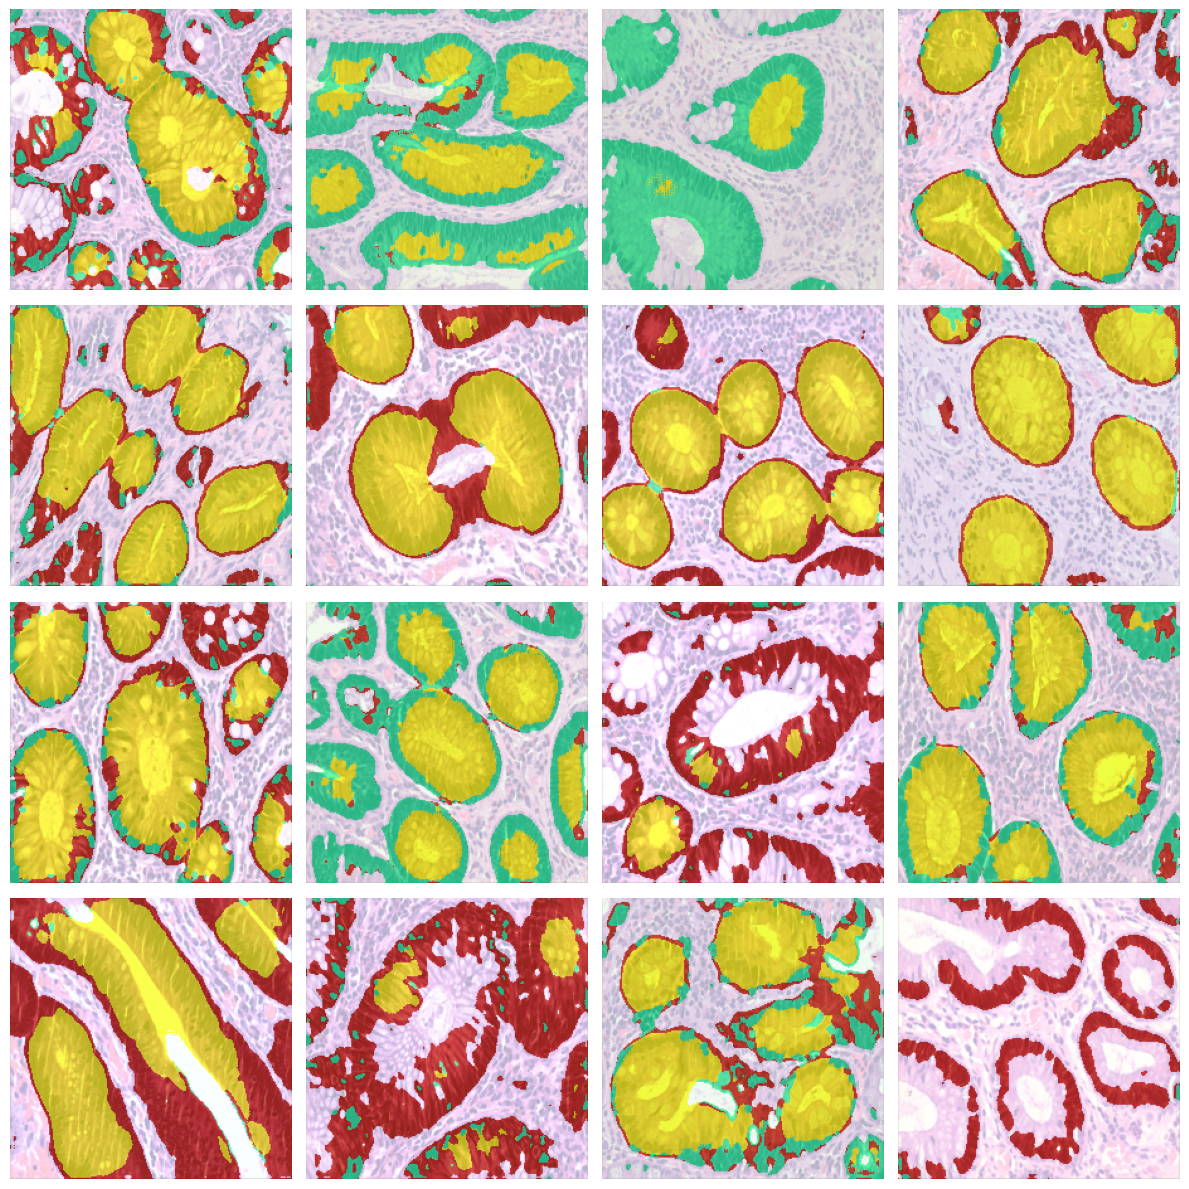

In [71]:
fig, axes = plt.subplots(4, 4, figsize=(12,12))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(overlay[i])
    ax.axis('off')

plt.tight_layout()
plt.show()